# Flu prediction - TechLabs Project 14: Curaio

This notebook contains the code for our TechLabs (https://tech-labs.de/) project Curaio. Our aim is to predict Influenza rates, more precisely Influenza like illnesses (ILI) rates, for the United States on the state level using Time Series data. We complement the historic data with Google Trends data for typical symptoms of influenza like illnesses.

The datasets are extracted from ILINet using R's cdcfluview package and from the (Pseudo) Google Trends API using PyTrends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from pytrends.request import TrendReq
import pytrends
from random import randint

## Exploratory Data Analysis: ILI Rates

In [72]:
# load ILI rates into dataframes
state_ili = pd.read_csv("ili_state_level.csv", header=0)
state_ili.head()

,Unnamed: 0,region_type,region,year,week,weighted_ili,unweighted_ili,age_0_4,age_25_49,age_25_64,age_5_24,age_50_64,age_65,ilitotal,num_of_providers,total_patients,week_start
0,1,States,Alabama,2014,40,NaN,1.731740,NaN,NaN,NaN,NaN,NaN,NaN,220.0,26.0,12704.0,NaN
1,2,States,Alaska,2014,40,NaN,0.437445,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,1143.0,NaN
2,3,States,Arizona,2014,40,NaN,1.029370,NaN,NaN,NaN,NaN,NaN,NaN,299.0,59.0,29047.0,NaN
3,4,States,Arkansas,2014,40,NaN,1.072390,NaN,NaN,NaN,NaN,NaN,NaN,48.0,17.0,4476.0,NaN
4,5,States,California,2014,40,NaN,1.908900,NaN,NaN,NaN,NaN,NaN,NaN,831.0,129.0,43533.0,NaN


In [58]:
state_ili.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 17 columns):
Unnamed: 0          13230 non-null int64
region_type         13230 non-null object
region              13230 non-null object
year                13230 non-null int64
week                13230 non-null int64
weighted_ili        17 non-null float64
unweighted_ili      12985 non-null float64
age_0_4             0 non-null float64
age_25_49           0 non-null float64
age_25_64           0 non-null float64
age_5_24            0 non-null float64
age_50_64           0 non-null float64
age_65              0 non-null float64
ilitotal            12985 non-null float64
num_of_providers    12985 non-null float64
total_patients      12985 non-null float64
week_start          0 non-null float64
dtypes: float64(12), int64(3), object(2)
memory usage: 1.7+ MB


In [73]:
# dropping count column, age* columns, weighted_ili, week_start
ili = state_ili.drop(["Unnamed: 0", "weighted_ili", "age_0_4", "age_25_49", "age_25_64", "age_5_24", "age_50_64", "age_65", "week_start"], axis=1)
ili.head()

,region_type,region,year,week,unweighted_ili,ilitotal,num_of_providers,total_patients
0,States,Alabama,2014,40,1.731740,220.0,26.0,12704.0
1,States,Alaska,2014,40,0.437445,5.0,7.0,1143.0
2,States,Arizona,2014,40,1.029370,299.0,59.0,29047.0
3,States,Arkansas,2014,40,1.072390,48.0,17.0,4476.0
4,States,California,2014,40,1.908900,831.0,129.0,43533.0


In [66]:
for y in [2014, 2015, 2016, 2017, 2018, 2019]:
    print(ili.loc[(ili["region"]=="Alabama") & (ili["year"]==y),:].week.count())

14
52
52
52
52
23


There are 14 weeks for 2014, 52 weeks for the years 2015 to 2018 and 23 weeks for 2019 included in the ILI time series.

In [67]:
ili.region.nunique()

54

In [68]:
ili.region.value_counts()

Nebraska                245
Michigan                245
Hawaii                  245
Arkansas                245
Utah                    245
Alabama                 245
Mississippi             245
Arizona                 245
Oregon                  245
New York City           245
Maine                   245
Oklahoma                245
Wyoming                 245
New Jersey              245
North Carolina          245
Kansas                  245
Indiana                 245
Illinois                245
Massachusetts           245
District of Columbia    245
New Mexico              245
Kentucky                245
Texas                   245
Vermont                 245
Nevada                  245
Puerto Rico             245
New Hampshire           245
South Dakota            245
South Carolina          245
Louisiana               245
Maryland                245
Montana                 245
West Virginia           245
Rhode Island            245
Delaware                245
Georgia             

There are 54 unique states. The 4 additional states are "District of Columbia", "New York City", "Puerto Rico" and "Virgin Islands". Since only the District of Columbia is included in Google Trends we drop the other three states from our data.

In [74]:
ili = ili.drop(ili[ili.region=="New York City"].index)
ili = ili.drop(ili[ili.region=="Puerto Rico"].index)
ili = ili.drop(ili[ili.region=="Virgin Islands"].index)
ili.region.nunique()

51

In [80]:
# setting the date as datetimeindex
ili["date"] = pd.to_datetime(ili.week.astype(str) + ili.year.astype(str).add("-0"), format="%W%Y-%w")
ili.set_index("date", inplace=True)

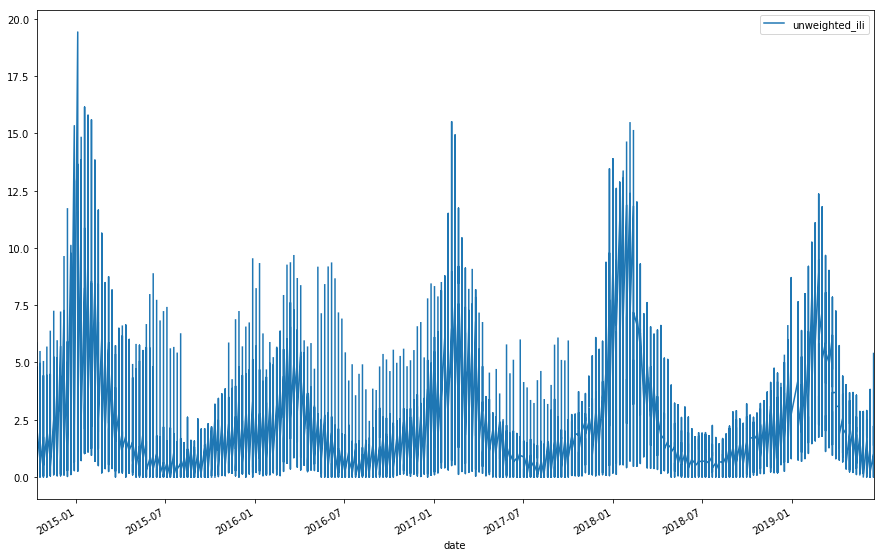

In [83]:
# plotting the data
ili.reset_index().plot(x="date", y="unweighted_ili", figsize=(15,10))

## Getting Google Trends Data

In [6]:
pytrends = TrendReq(hl='en-US', tz=360)

In [11]:
# getting data for all states
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
states = ["AL", "AZ"]
trends_data = pd.DataFrame()
for state in states:
    geo = str("US-" + str(state))
    pytrends.build_payload(kw_list, cat=0, timeframe="today 5-y", geo=geo)
    trends_state = pytrends.interest_over_time()
    trends_state["state"] = state
    trends_data = pd.concat([trends_data, trends_state])

In [19]:
trends_data.state.value_counts()

AZ    261
AL    261
Name: state, dtype: int64

In [20]:
# getting data for NY
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo='US-NY')
trends_ny = pytrends.interest_over_time()
trends_ny = trends_ny.drop("isPartial", axis=1)

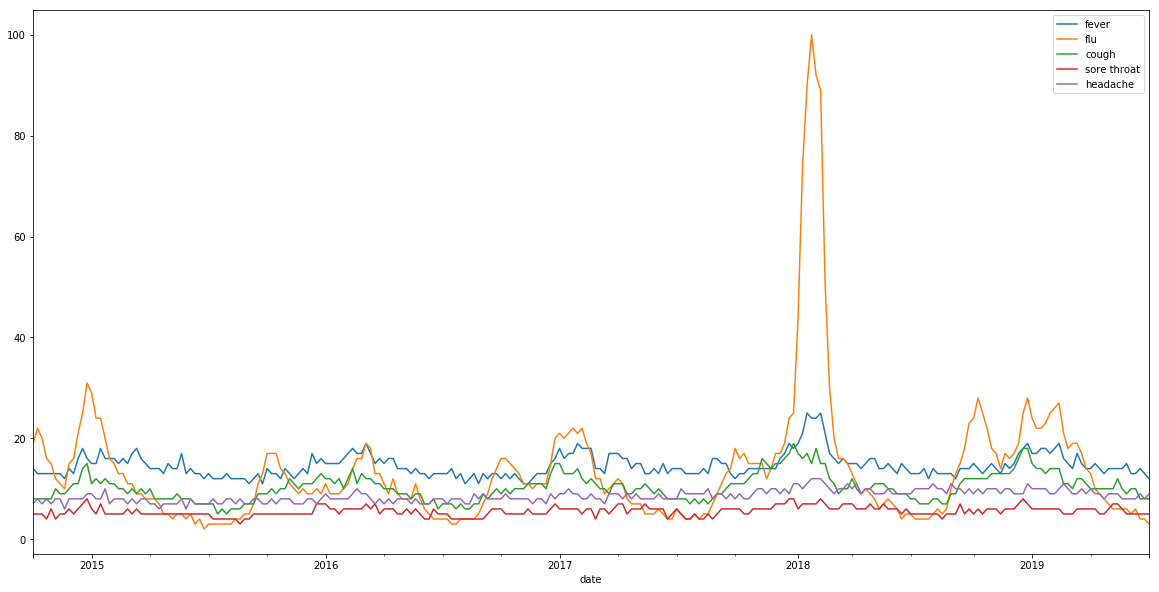

In [21]:
trends_ny.plot(figsize=(20,10))

In [22]:
ili_ny = ili.loc[ili["region"]=="New York",:]

In [28]:
trends_ny.head()

,fever,flu,cough,sore throat,headache
date,,,,,
2014-10-05,14,19,8,5,7
2014-10-12,13,22,8,5,8
2014-10-19,13,20,8,5,7
2014-10-26,13,16,8,4,8
2014-11-02,13,15,8,6,7


In [23]:
ili_ny["date"] = pd.to_datetime(ili_ny.week.astype(str) + ili_ny.year.astype(str).add("-0"), format="%W%Y-%w")
ili_ny[ili_ny["year"]==2015]
# get datetimeindex from Date column
ili_ny.set_index("date", inplace=True)

C:\Users\Tobi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [148]:
trends_ny.head()

,fever,flu,cough,sore throat,headache
date,,,,,
2014-10-05,13,18,8,5,7
2014-10-12,13,22,8,5,7
2014-10-19,13,20,7,4,8
2014-10-26,14,14,9,4,7
2014-11-02,14,15,8,5,8


In [24]:
# merge the dataframes on the Datetimeindex
merged = trends_ny.join(ili_ny)

In [154]:
merged.head()

,fever,flu,cough,sore throat,headache,region_type,region,year,week,unweighted_ili,ilitotal,num_of_providers,total_patients
date,,,,,,,,,,,,,
2014-10-05,13,18,8,5,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-12,13,22,8,5,7,States,New York,2014.0,40.0,0.693823,124.0,153.0,17872.0
2014-10-19,13,20,7,4,8,States,New York,2014.0,41.0,0.609081,110.0,155.0,18060.0
2014-10-26,14,14,9,4,7,States,New York,2014.0,42.0,0.768460,138.0,157.0,17958.0
2014-11-02,14,15,8,5,8,States,New York,2014.0,43.0,0.872553,160.0,159.0,18337.0


In [25]:
merged = merged.dropna(axis=0)
merged.head()

,fever,flu,cough,sore throat,headache,region_type,region,year,week,unweighted_ili,ilitotal,num_of_providers,total_patients
date,,,,,,,,,,,,,
2014-10-12,13,22,8,5,8,States,New York,2014.0,40.0,0.693823,124.0,153.0,17872.0
2014-10-19,13,20,8,5,7,States,New York,2014.0,41.0,0.609081,110.0,155.0,18060.0
2014-10-26,13,16,8,4,8,States,New York,2014.0,42.0,0.768460,138.0,157.0,17958.0
2014-11-02,13,15,8,6,7,States,New York,2014.0,43.0,0.872553,160.0,159.0,18337.0
2014-11-09,13,12,10,4,8,States,New York,2014.0,44.0,0.951770,178.0,161.0,18702.0


In [26]:
merged["wordlist"] = merged.fever + merged.flu + merged.cough + merged["sore throat"] + merged.headache

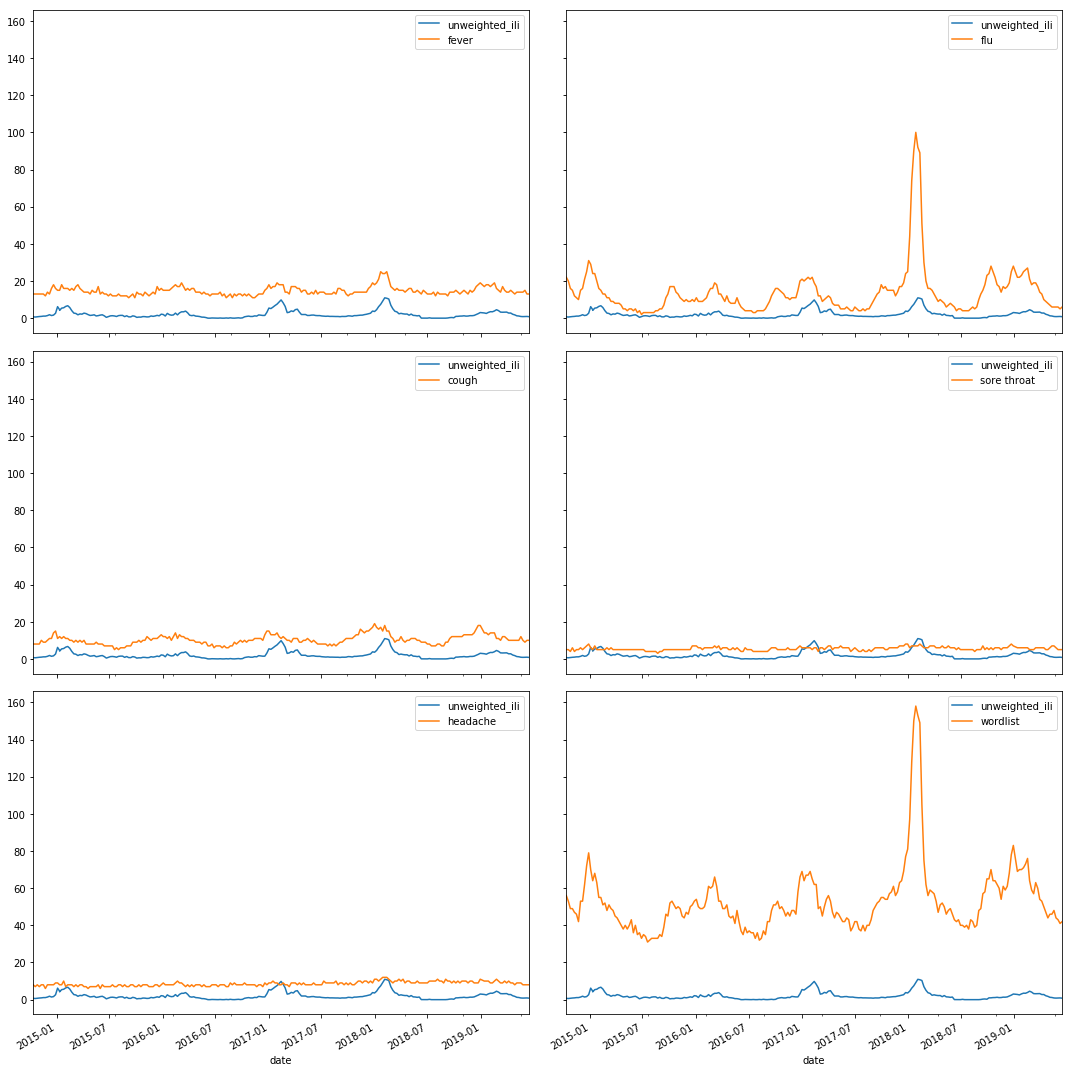

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

In [197]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged["unweighted_ili"].corr(merged[var])))

Corr. Coef. between unweighted_ili and flu: 0.6855487382137291
Corr. Coef. between unweighted_ili and fever: 0.767594012929822
Corr. Coef. between unweighted_ili and cough: 0.5618366450299008
Corr. Coef. between unweighted_ili and sore throat: 0.3559449166465167
Corr. Coef. between unweighted_ili and headache: 0.29754839764624225
Corr. Coef. between unweighted_ili and wordlist: 0.7172691369247071


## Correlation with lagged ili rates

In [46]:
# ili_ny: dates are in year + week; conversion into dates seems wrong? e.g. for 2015 the first week ends on Sunday the 4th of January 
ili_ny[ili_ny.year==2015]
ili_ny_shifted = ili_ny.shift(-1, freq='W')

# create merged data frame
merged_shifted = trends_ny.join(ili_ny_shifted)
merged_shifted = merged_shifted.dropna(axis=0)
merged_shifted["wordlist"] = merged_shifted.fever + merged_shifted.flu + merged_shifted.cough + merged_shifted["sore throat"] + merged_shifted.headache
merged_shifted.head()

,fever,flu,cough,sore throat,headache,region_type,region,year,week,unweighted_ili,ilitotal,num_of_providers,total_patients,wordlist
date,,,,,,,,,,,,,,
2014-10-05,14,19,8,5,7,States,New York,2014.0,40.0,0.693823,124.0,153.0,17872.0,53
2014-10-12,13,22,8,5,8,States,New York,2014.0,41.0,0.609081,110.0,155.0,18060.0,56
2014-10-19,13,20,8,5,7,States,New York,2014.0,42.0,0.768460,138.0,157.0,17958.0,53
2014-10-26,13,16,8,4,8,States,New York,2014.0,43.0,0.872553,160.0,159.0,18337.0,49
2014-11-02,13,15,8,6,7,States,New York,2014.0,44.0,0.951770,178.0,161.0,18702.0,49


In [47]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged_shifted["unweighted_ili"].corr(merged_shifted[var])))

Corr. Coef. between unweighted_ili and flu: 0.7418251144275874
Corr. Coef. between unweighted_ili and fever: 0.8001679632162869
Corr. Coef. between unweighted_ili and cough: 0.6216544278555095
Corr. Coef. between unweighted_ili and sore throat: 0.4630174295709187
Corr. Coef. between unweighted_ili and headache: 0.3649013260981731
Corr. Coef. between unweighted_ili and wordlist: 0.7805192342535545


The correlation is higher for the shifted ili_ny datasets. This indicates that the conversion of week numbers into specific dates was actually wrong.

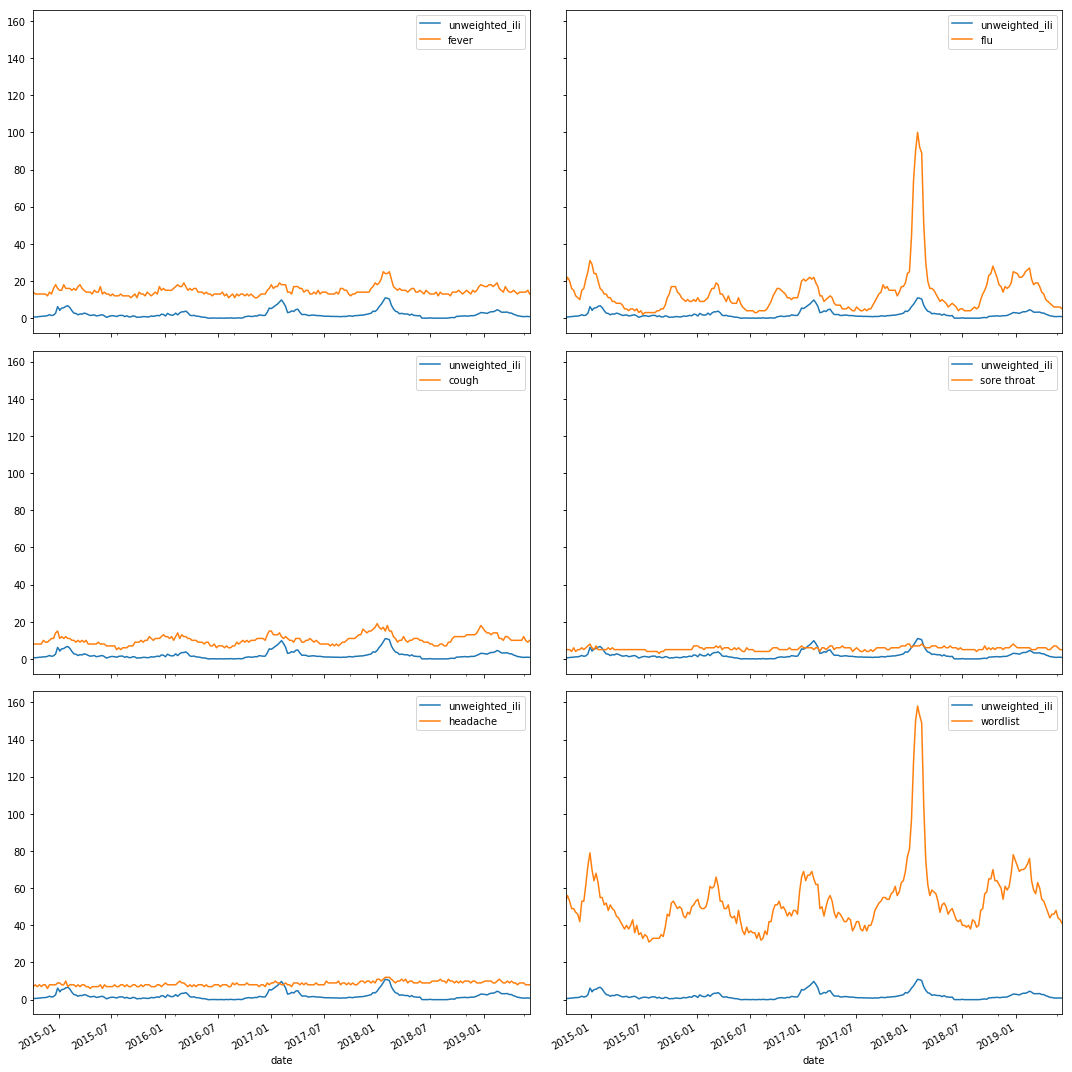

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged_shifted.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

## Looking at national level data

In [5]:
ili_us = pd.read_csv("ili_national_level.csv", header=0)
# setting the date as datetimeindex
ili_us["date"] = pd.to_datetime(ili_us.week.astype(str) + ili_us.year.astype(str).add("-0"), format="%W%Y-%w")
ili_us.set_index("date", inplace=True)
# shifting the datetimeindex one week back
ili_us_shifted = ili_us.shift(-1, freq='W')

In [7]:
pytrends = TrendReq(hl='en-US', tz=360)

In [8]:
# getting google Trends data
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
pytrends.build_payload(kw_list, cat=0, timeframe="2014-09-29 2019-07-07", geo='US')
trends_us = pytrends.interest_over_time()
trends_us = trends_us.drop("isPartial", axis=1)

In [12]:
# merge the dataframes on the Datetimeindex
merged_us = trends_us.join(ili_us_shifted)
merged_us["wordlist"] = merged_us.fever + merged_us.flu + merged_us.cough + merged_us["sore throat"] + merged_us.headache

In [13]:
for var in ["flu", "fever", "cough", "sore throat", "headache", "wordlist"]:
    print("Corr. Coef. between unweighted_ili and " + var + ": " + str(merged_us["unweighted_ili"].corr(merged_us[var])))

Corr. Coef. between unweighted_ili and flu: 0.8327827006014822
Corr. Coef. between unweighted_ili and fever: 0.8933627771176674
Corr. Coef. between unweighted_ili and cough: 0.8596499606466077
Corr. Coef. between unweighted_ili and sore throat: 0.7434206280373575
Corr. Coef. between unweighted_ili and headache: 0.4195012416287994
Corr. Coef. between unweighted_ili and wordlist: 0.9052926986475428


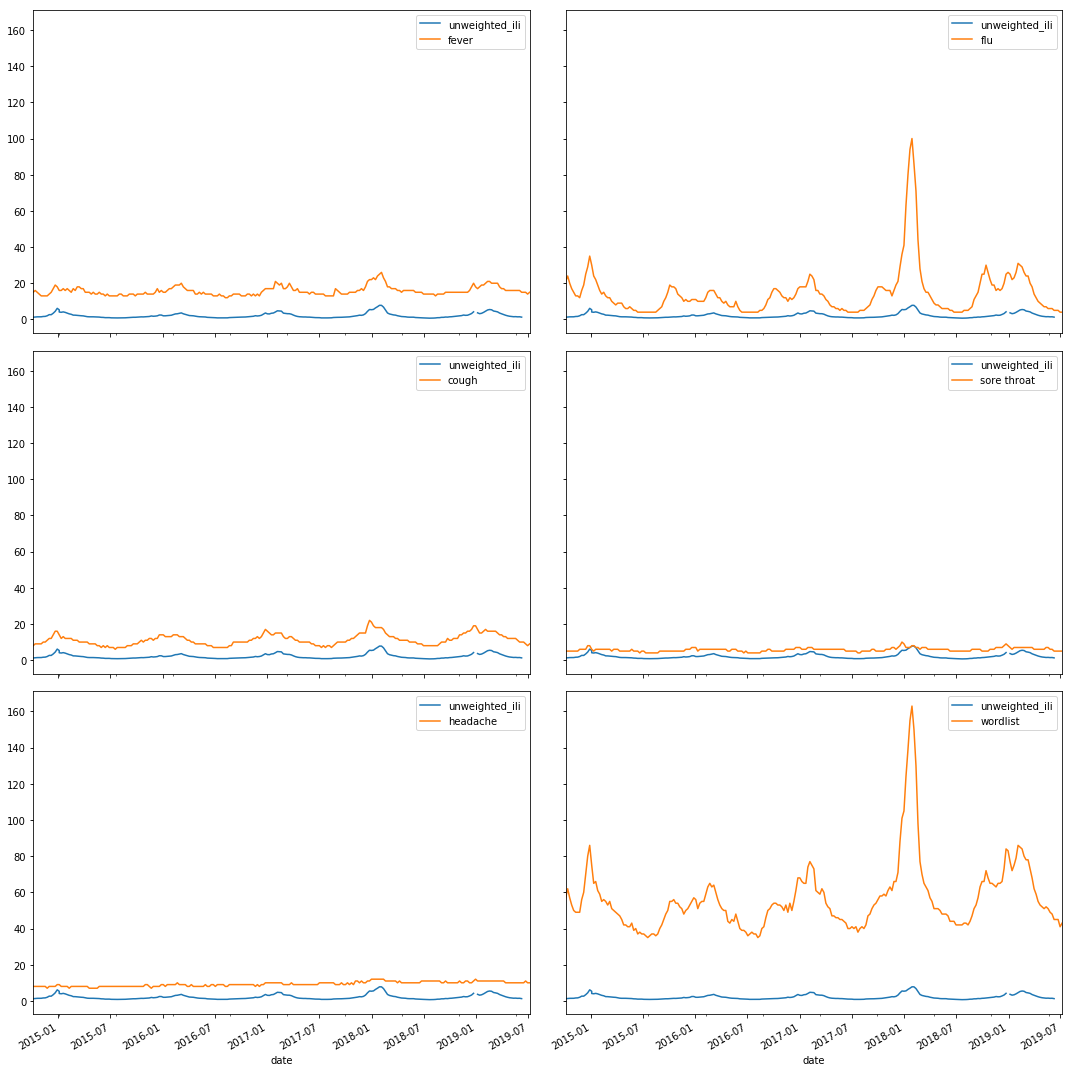

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,15))

merged_us.reset_index().plot(x="date", y=["unweighted_ili", "fever"], ax=axes[0,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "flu"], ax=axes[0,1])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "cough"], ax=axes[1,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "sore throat"], ax=axes[1,1])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "headache"], ax=axes[2,0])
merged_us.reset_index().plot(x="date", y=["unweighted_ili", "wordlist"], ax=axes[2,1])
plt.tight_layout()

## To Do 

- getting Google Trends Data for all states -> update the list with the state abbreviations from Google Trends
- combine ili rates and Google Trends data for all states in a single DataFrame
- getting another list of symptoms from google trends (max. 5 keywords per search) 
- keywords alone or in combination?
- mean correlation over all states
- missings on national level data for ili rates